In [1]:
!pip install gymnasium
!pip install gymnasium[mujoco]

   ━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━ 958.1/958.1 kB 10.2 MB/s eta 0:00:00
     ━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━ 44.4/44.4 kB 419.5 kB/s eta 0:00:00
   ━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━ 6.3/6.3 MB 39.5 MB/s eta 0:00:00
   ━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━ 211.8/211.8 kB 13.7 MB/s eta 0:00:00


Episode: 0, Average Reward: 0
Episode: 1000, Average Reward: -4
Episode: 2000, Average Reward: 0
Episode: 3000, Average Reward: 17
Episode: 4000, Average Reward: 82
Episode: 0, Average Reward: 156
Episode: 1000, Average Reward: 1
Episode: 2000, Average Reward: 8
Episode: 3000, Average Reward: 103
Episode: 4000, Average Reward: 137
Episode: 0, Average Reward: 172
Episode: 1000, Average Reward: 15
Episode: 2000, Average Reward: 40
Episode: 3000, Average Reward: 92
Episode: 4000, Average Reward: 133
Episode: 0, Average Reward: 142
Episode: 1000, Average Reward: 27
Episode: 2000, Average Reward: 89
Episode: 3000, Average Reward: 162
Episode: 4000, Average Reward: 232
Episode: 0, Average Reward: 235
Episode: 1000, Average Reward: 10
Episode: 2000, Average Reward: 51
Episode: 3000, Average Reward: 150
Episode: 4000, Average Reward: 220


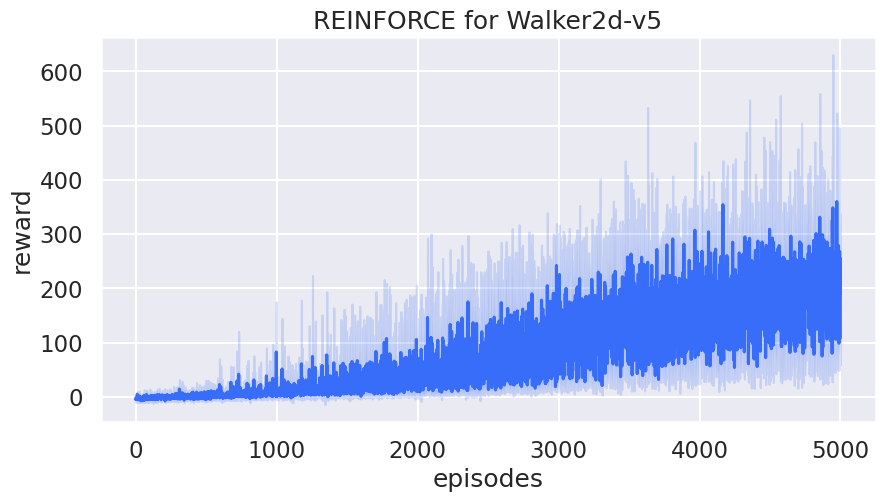

In [2]:
from __future__ import annotations

import random
import matplotlib.pyplot as plt
import numpy as np
import pandas as pd
import seaborn as sns
import torch
import torch.nn as nn
from torch.distributions.normal import Normal
import gymnasium as gym

plt.rcParams["figure.figsize"] = (10, 5)

class Policy_Network(nn.Module):
    """Parametrized Policy Network."""

    def __init__(self, obs_space_dims: int, action_space_dims: int):
        super().__init__()

        hidden_space1 = 16
        hidden_space2 = 32

        # Shared Network
        self.shared_net = nn.Sequential(
            nn.Linear(obs_space_dims, hidden_space1),
            nn.Tanh(),
            nn.Linear(hidden_space1, hidden_space2),
            nn.Tanh(),
        )

        # Policy Mean specific Linear Layer
        self.policy_mean_net = nn.Sequential(
            nn.Linear(hidden_space2, action_space_dims)
        )

        # Policy Std Dev specific Linear Layer
        self.policy_stddev_net = nn.Sequential(
            nn.Linear(hidden_space2, action_space_dims)
        )

    def forward(self, x: torch.Tensor) -> tuple[torch.Tensor, torch.Tensor]:
        shared_features = self.shared_net(x.float())

        action_means = self.policy_mean_net(shared_features)
        action_stddevs = torch.log(
            1 + torch.exp(self.policy_stddev_net(shared_features))
        )

        return action_means, action_stddevs

class REINFORCE:
    """REINFORCE algorithm."""

    def __init__(self, obs_space_dims: int, action_space_dims: int):
        # Hyperparameters
        self.learning_rate = 1e-4  # Learning rate for policy optimization
        self.gamma = 0.99  # Discount factor
        self.eps = 1e-6  # small number for mathematical stability

        self.probs = []  # Stores probability values of the sampled action
        self.rewards = []  # Stores the corresponding rewards

        self.net = Policy_Network(obs_space_dims, action_space_dims)
        self.optimizer = torch.optim.AdamW(self.net.parameters(), lr=self.learning_rate)

    def sample_action(self, state: np.ndarray) -> float:
        state = torch.tensor(np.array([state]))
        action_means, action_stddevs = self.net(state)

        # create a normal distribution from the predicted mean and standard deviation
        distrib = Normal(action_means[0] + self.eps, action_stddevs[0] + self.eps)
        action = distrib.sample()
        prob = distrib.log_prob(action)

        action = action.numpy()
        self.probs.append(prob)

        return action

    def update(self):
        running_g = 0
        gs = []

        # Discounted return (backwards)
        for R in self.rewards[::-1]:
            running_g = R + self.gamma * running_g
            gs.insert(0, running_g)

        deltas = torch.tensor(gs)

        log_probs = torch.stack(self.probs)

        # Calculate loss
        log_prob_mean = log_probs.mean()
        loss = -torch.sum(log_prob_mean * deltas)

        # Update the policy network
        self.optimizer.zero_grad()
        loss.backward()
        self.optimizer.step()

        # Reset episode-specific arrays
        self.probs = []
        self.rewards = []

# Create and wrap the environment
env = gym.make("Walker2d-v5")  # Using Walker2d-v5 environment
wrapped_env = gym.wrappers.RecordEpisodeStatistics(env, 50)  # Records episode-reward

total_num_episodes = int(5e3)  # Total number of episodes
obs_space_dims = env.observation_space.shape[0]  # 17 for Walker2d-v4
action_space_dims = env.action_space.shape[0]  # 6 for Walker2d-v4
rewards_over_seeds = []

for seed in [1, 2, 3, 5, 8]:  # Fibonacci seeds
    # set seed
    torch.manual_seed(seed)
    random.seed(seed)
    np.random.seed(seed)

    # Reinitialize agent every seed
    agent = REINFORCE(obs_space_dims, action_space_dims)
    reward_over_episodes = []

    for episode in range(total_num_episodes):
        obs, info = wrapped_env.reset(seed=seed)

        done = False
        while not done:
            action = agent.sample_action(obs)
            obs, reward, terminated, truncated, info = wrapped_env.step(action)
            agent.rewards.append(reward)
            done = terminated or truncated

        reward_over_episodes.append(wrapped_env.return_queue[-1])
        agent.update()

        if episode % 1000 == 0:
            avg_reward = int(np.mean(wrapped_env.return_queue))
            print(f"Episode: {episode}, Average Reward: {avg_reward}")

    rewards_over_seeds.append(reward_over_episodes)

# Plot learning curve - Fixed plotting code
df1 = pd.DataFrame(rewards_over_seeds).T  # Transpose to get episodes as rows
df1 = df1.reset_index().melt(id_vars=['index'])
df1.rename(columns={"index": "episodes", "value": "reward", "variable": "seed"}, inplace=True)

sns.set(style="darkgrid", context="talk", palette="rainbow")
sns.lineplot(x="episodes", y="reward", data=df1).set(
    title="REINFORCE for Walker2d-v5"
)
plt.show()

## Reflection
1. We don't start to see meaningful progress till around 2000-3000 episodes.You can see this pattern across all the seeds where reqards starts to increase from near-zero to double or triple digits. In the last run (seed 4), rewards went from 10 at episode 1000 to 51 at episode 2000, then jumped to 150 by episode 3000.
2. Early stage (0-1000 episdoes) the perfomance is very poor (rewards beteen 0-27). The agent is mostly learning basic movements. Mid stage (1000-3000 episodes) start to see gradual improvement with rewards between 40-100. Late stage (3000-5000 episodes) start to see significant improvement with rewards reaching 150-235. A more stable walking pattern starts to emerge.

3. Potential Improvements: There are three potential improvements we talked about implementing if we had more time. We would increase the network capacity and add another layer. We would also adjust the hyperparameters and use a slightly higher learning rate and discount factor. One last thing we might add is reward normalization. A combination of these would be a simple way to improve performance.